In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

Construct cells immediately below this that **build a word2vec model** with your corpus. Interrogate word relationships in the resulting space, including **estimating 90% confidence intervals** for specific word cosine distances of interest. **Plot a subset of your words**. What do these word relationships reveal about the social and cultural game underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

In [3]:
all_news = pandas.read_csv("fake.csv")
all_news.head(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [4]:
print("Types and counts of stories", all_news.groupby(["type"]).size())


Types and counts of stories type
bias            443
bs            11492
conspiracy      430
fake             19
hate            246
junksci         102
satire          146
state           121
dtype: int64


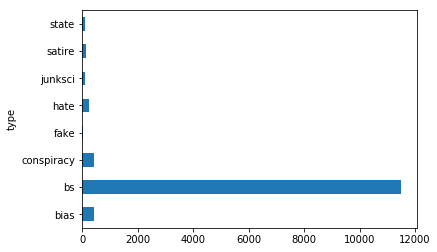

In [5]:
all_news.groupby(['type']).size().plot(kind='barh')

In [6]:
#fake_news = all_news[all_news["type"] == "fake"]

In [14]:

# Fill any blank fields
all_news.title.fillna("", inplace=True)
all_news.text.fillna("", inplace=True)

There is some issue with the Lucem package. Therefore, I am declaring the necessary functions below.

In [15]:
stop_words_basic = nltk.corpus.stopwords.words('english')
stemmer_basic = nltk.stem.snowball.SnowballStemmer('english')
lemmer_basic = nltk.stem.WordNetLemmatizer()


def normalizeTokens(tokenLst,stopwordLst = None,stemmer = None,lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

In [16]:
#Apply our functions, notice each row is a list of lists now
all_news['tokenized_sents'] = all_news['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
all_news['normalized_sents'] = all_news['tokenized_sents'].apply(lambda x: 
                                                                           [normalizeTokens(s, 
                                                                                           stopwordLst = stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

all_news[:5]

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,...,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,tokenized_sents,normalized_sents
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[[Print, They, should, pay, all, the, back, al...","[[print, pay, back, money, plus, interest], [e..."
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[[Why, Did, Attorney, General, Loretta, Lynch,...","[[attorney, general, loretta, lynch, plead, fi..."
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[[Red, State, :, Fox, News, Sunday, reported, ...","[[red, state, fox, news, sunday, reported, mor..."
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,"[[Email, Kayla, Mueller, was, a, prisoner, and...","[[email, kayla, mueller, prisoner, tortured, i..."
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,"[[Email, HEALTHCARE, REFORM, TO, MAKE, AMERICA...","[[email, healthcare, reform, make, america, gr..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences

In [17]:
all_news_W2V = gensim.models.word2vec.Word2Vec(all_news['normalized_sents'].sum())

Taking a preliminary look...

In [28]:
print("A {} dimesional vector:".format(all_news_W2V['fake'].shape[0]))
all_news_W2V['fake']

A 100 dimesional vector:


array([ 0.02612005,  1.33090055, -0.42821753, -0.22536232, -0.69750863,
       -1.19530785, -0.40748772,  0.95551348, -1.66085005,  2.07719684,
        0.61895263, -1.06222034, -1.62382233,  0.8373419 , -0.40438166,
        1.03203869,  1.62072361,  0.81675327, -0.11761047,  0.58405179,
       -1.48736823, -0.28385627, -0.18710454, -0.97844899, -1.22849965,
        0.58394849,  0.74322653,  1.28429985,  0.09963571, -1.36879599,
       -0.998833  , -0.11128613,  0.37058502, -1.16836894,  0.45738551,
        0.55778539,  0.11758573, -0.18227276,  1.33373821,  0.22491725,
        0.24126039, -0.39255154, -0.08555374, -0.61051488, -0.10112283,
        1.22644675,  0.13196972,  0.00487288, -1.365798  ,  0.19166808,
       -0.88047713, -1.41260505,  0.23002547,  2.29325175, -0.62495416,
       -1.32352006, -1.56146801,  0.14945138,  1.64142537,  0.68462253,
        0.68680573,  0.11384588, -0.61737299,  0.29991022,  0.42595518,
       -0.56549358, -0.44072545,  0.27689657,  2.28878856,  0.79

Then, `index2word` lets you translate from the matrix to words

In [26]:
all_news_W2V.wv.index2word[111]

'foreign'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [46]:
all_news_W2V.most_similar('hillary')

[('hilary', 0.6899990439414978),
 ('mrs', 0.6114938259124756),
 ('hawkishness', 0.5717636942863464),
 ('scandal', 0.5286740064620972),
 ('killary', 0.512967050075531),
 ('scandals', 0.5060487985610962),
 ('hrc', 0.5011767745018005),
 ('aides', 0.4810004234313965),
 ('hilliary', 0.47696414589881897),
 ('transact', 0.47541433572769165)]

In [30]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [32]:
cos_difference(all_news_W2V, 'fake', 'president')

array([[-2.]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [37]:
all_news_W2V.doesnt_match(['false', 'fake', 'president', 'clinton', 'republican'])

'president'

It is interesting to note that in the corpus of fake news analyzed, the most dissimilar word from the list presented above is `president`. The observation is interesting because given that `republican` is in the word list, it should have been intuitively the odd word out. But the fact that `clinton` or `republican` does not stand out says that Clinton may be associated more with negative narratives as shown in the result above.  

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [52]:
all_news_W2V.most_similar(positive=['hillary', 'conservative'], negative = ['trump'])

[('liberal', 0.5741316080093384),
 ('progressive', 0.5161784887313843),
 ('leftist', 0.5140464901924133),
 ('promoted', 0.4814240634441376),
 ('libertarian', 0.47943657636642456),
 ('touted', 0.462809681892395),
 ('centrist', 0.4616529941558838),
 ('politics', 0.45008179545402527),
 ('legalise', 0.44649243354797363),
 ('prominent', 0.444642037153244)]

The most intuitive check is as we find, Hillary is to Liberal and Progressive as Trump is to conservatives. It is interesting to note that `libertarian` also somehow features in this relation.

What happens instead we consider Trump as a centrist? What would that make Hillary?

In [55]:
all_news_W2V.most_similar(positive=['hillary', 'centrist'], negative = ['trump'])

[('promoted', 0.5403199791908264),
 ('leaning', 0.5367637872695923),
 ('funders', 0.5330397486686707),
 ('favoring', 0.5261191129684448),
 ('dynasty', 0.5217596888542175),
 ('arenas', 0.5153677463531494),
 ('leftist', 0.5055137872695923),
 ('warmongering', 0.49962323904037476),
 ('interventionists', 0.4959533214569092),
 ('achilles', 0.49420449137687683)]

We see that the closest relevant match is where Hillary is related to `leftist`.

Looking at their relationships to `war`. If we assume Trump is strongly related to `war`, how does Hillary fare? Also notice the most simlar words to Hillary. They all reflect the terms usually associated with 

In [56]:
all_news_W2V.most_similar(positive=['hillary', 'war'], negative = ['trump'])

[('wars', 0.5764915943145752),
 ('invasion', 0.4332573711872101),
 ('ww', 0.4286503195762634),
 ('libya', 0.4176904559135437),
 ('unindicted', 0.40638211369514465),
 ('wmd', 0.40280210971832275),
 ('disarmament', 0.39761435985565186),
 ('intervention', 0.39214906096458435),
 ('reign', 0.39159247279167175),
 ('afghanistan', 0.38882529735565186)]

Not very different. Both Hillary and Trump are therefore associated with `war`. 

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals


### Bootstrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [60]:
all_news_df=all_news[:1000]

In [61]:
estimatesB=[]
for x in range(20):
    all_news_W2VB = gensim.models.word2vec.Word2Vec(all_news_df['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(all_news_W2VB, 'fake', 'trump')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[-3.6893488e+19,
 -3.6893488e+19,
 -2.0,
 -2.0,
 -2.0,
 -1.0842022e-19,
 -1.0842022e-19,
 -1.0842022e-19,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 3.6893488e+19]

In [62]:
print("The 90% confidence interval for the cosine distance between fake and trump is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between fake and trump is:
 -3.68935e+19 2.0


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [67]:
n_samples = 40
sample_indices = np.random.randint(0,n_samples,(len(all_news),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(all_news[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'fake', 'trump')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(all_news[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[  2.00000000e+00  -3.68934881e+19  -2.00000000e+00   1.08420217e-19
  -3.68934881e+19   2.00000000e+00   2.00000000e+00  -2.00000000e+00
   0.00000000e+00  -2.00000000e+00   0.00000000e+00  -3.68934881e+19
   1.08420217e-19  -3.68934881e+19  -2.00000000e+00   0.00000000e+00
  -2.00000000e+00   2.00000000e+00   3.68934881e+19  -3.68934881e+19
   1.08420217e-19   3.68934881e+19   1.08420217e-19  -2.00000000e+00
   0.00000000e+00   0.00000000e+00   1.08420217e-19   2.00000000e+00
   1.08420217e-19  -1.08420217e-19  -1.08420217e-19   3.68934881e+19
  -3.68934881e+19  -1.08420217e-19  -1.08420217e-19   2.00000000e+00
  -1.08420217e-19   3.68934881e+19   0.00000000e+00   2.00000000e+00]
[ 311.  339.  337.  311.  329.  305.  306.  324.  315.  307.  336.  332.
  289.  319.  346.  391.  330.  318.  331.  310.  342.  313.  346.  319.
  320.  334.  333.  336.  323.  356.  294.  318.  324.  333.  330.  333.
  316.  327.  287.  329.]


In [68]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between war and responsibility is:
 -1.86085389449e+18 4.09706511717e+18


We can also save the vectors for later use:

In [69]:
all_news_W2V.save("all_news_WORD2Vec.mm")

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [70]:
numWords = 150
targetWords = all_news_W2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [71]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(all_news_W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.43040457, -0.32920691, -0.39360851, ..., -0.15577826,
        -1.9054414 ,  1.79086816],
       [ 0.17062843,  0.82252777, -0.23969658, ...,  0.70840609,
         0.19444622,  0.64292282],
       [ 1.26005721, -0.34116974,  2.06491232, ...,  1.35954535,
         1.10911584,  0.18412621],
       ..., 
       [ 1.39822114,  0.22574516, -0.970469  , ...,  1.47110951,
        -0.08786713,  0.79464781],
       [-1.30598497, -0.25498083, -2.37850618, ...,  1.37476039,
        -0.57630676,  1.64248228],
       [ 0.03219613, -1.86950493,  0.07434556, ...,  1.19267642,
        -0.92637616,  0.38299125]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [72]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

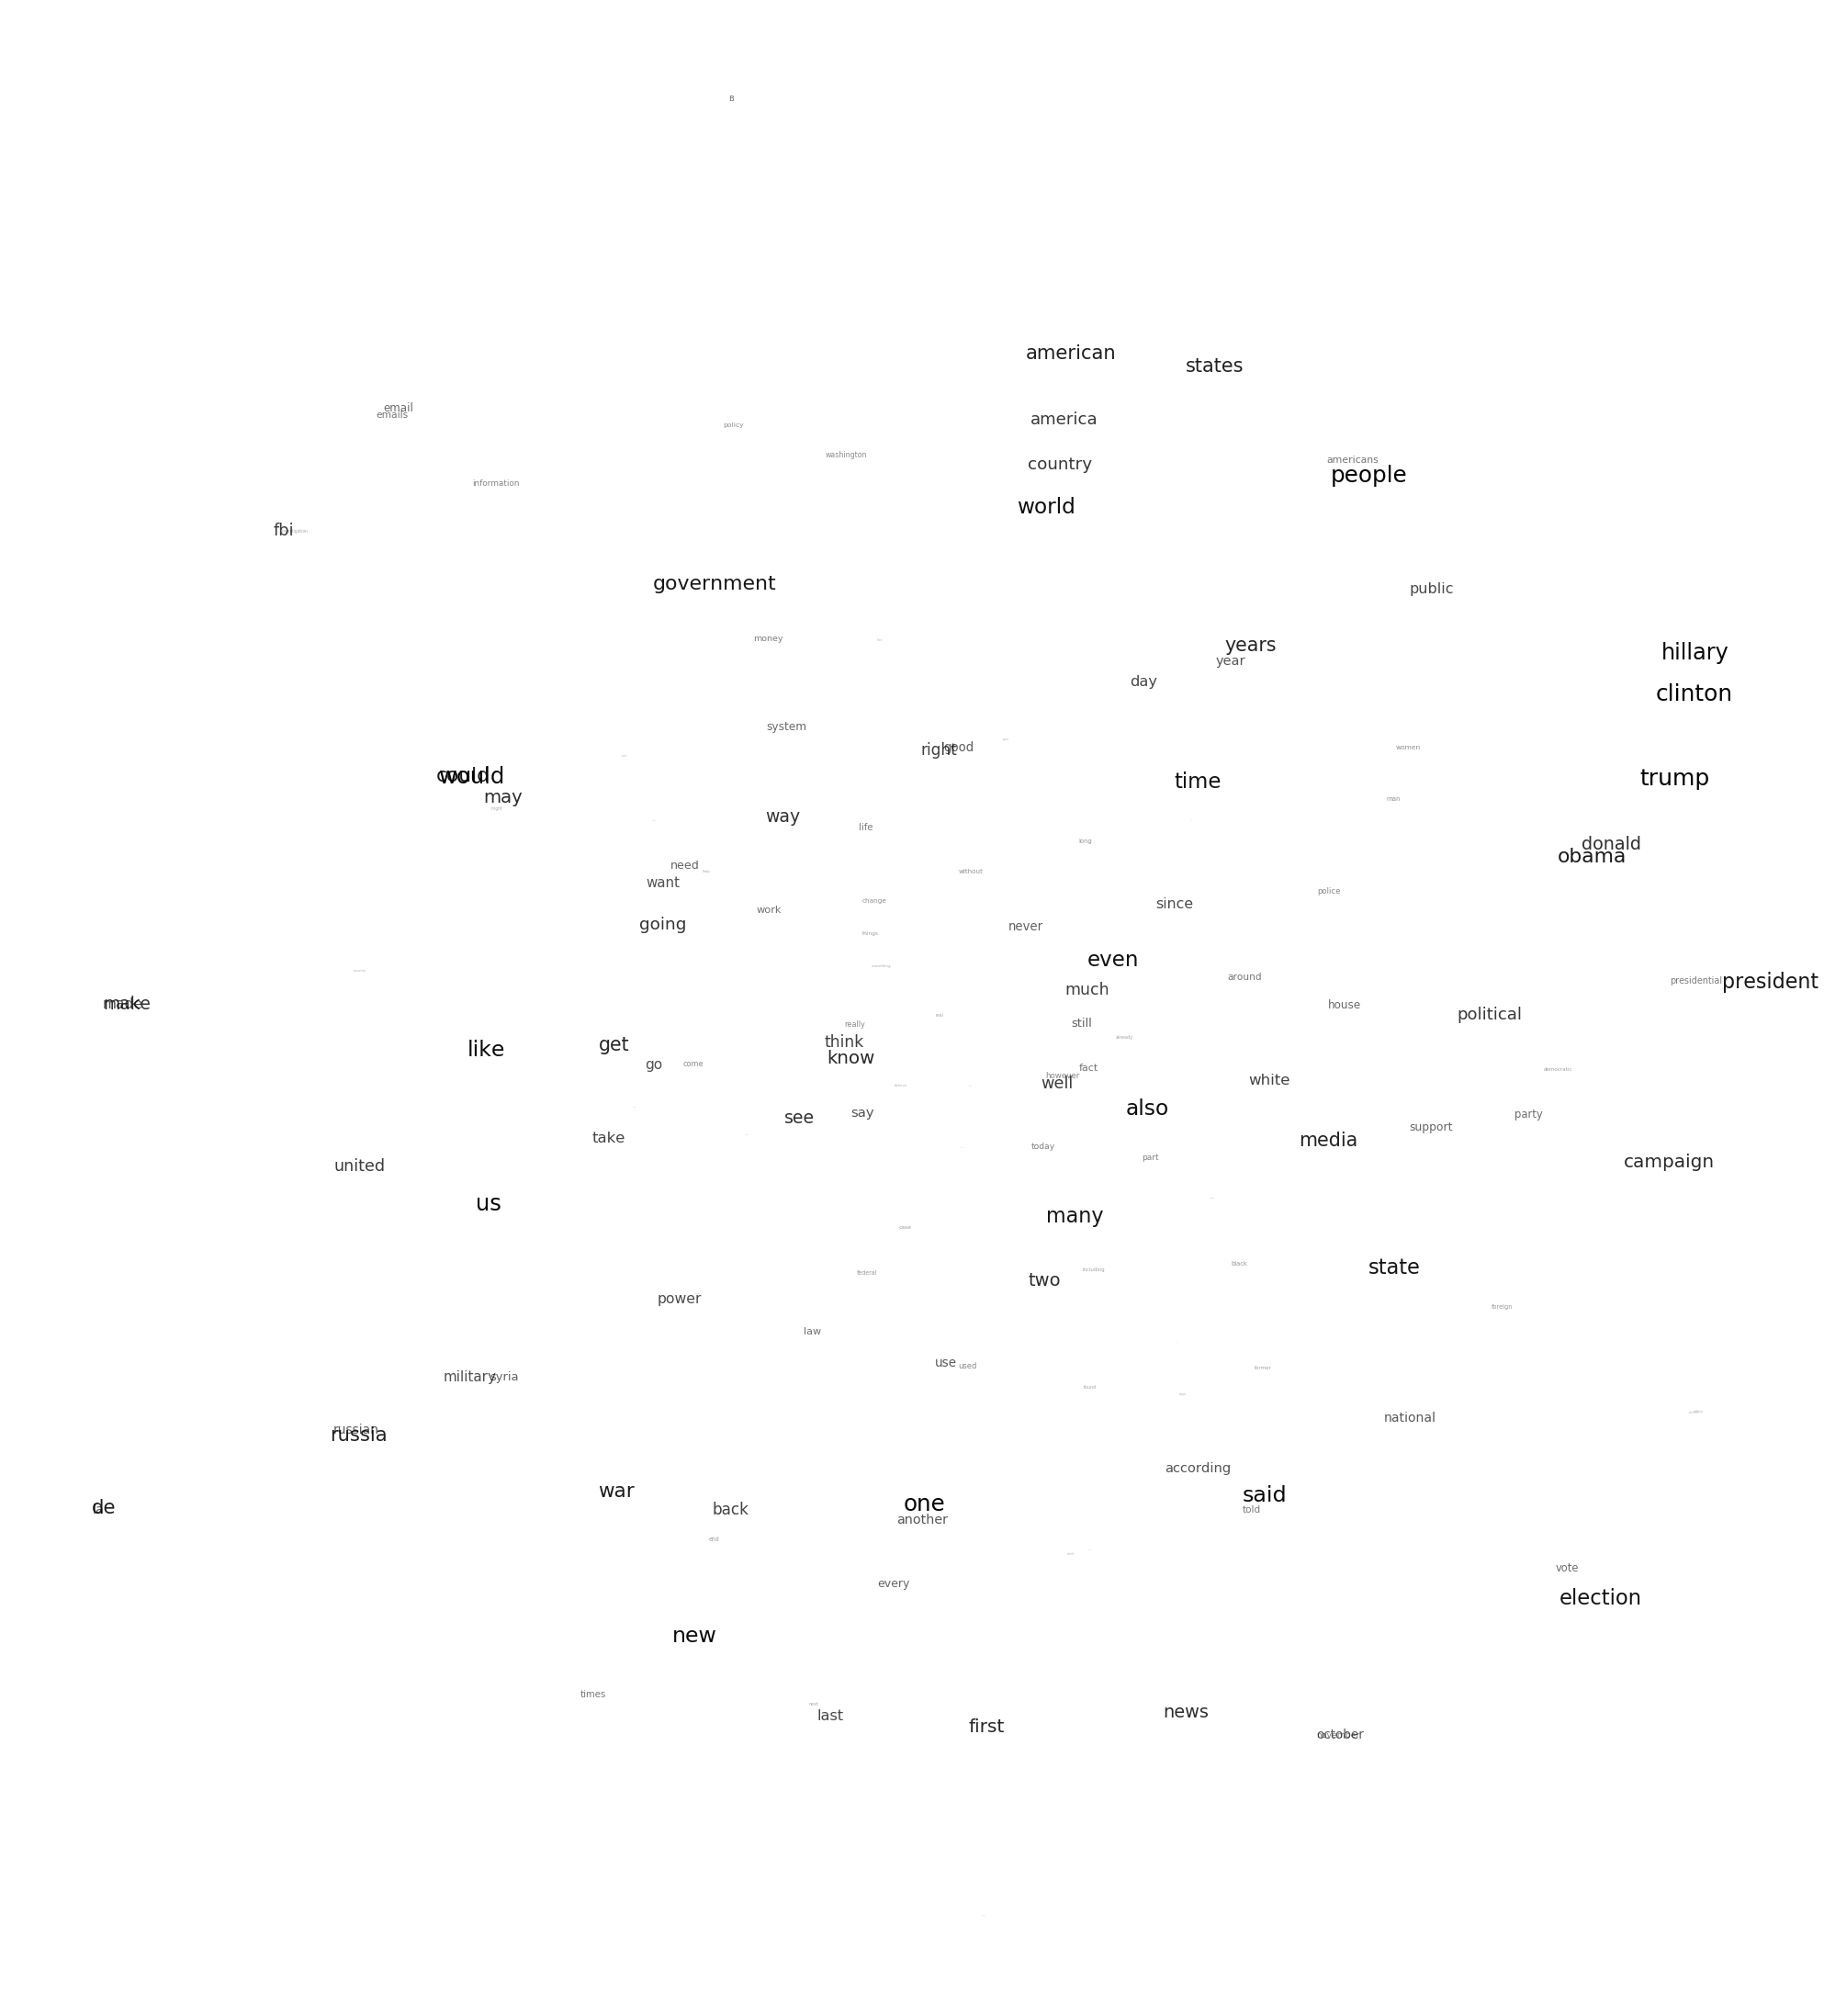

In [77]:
fig = plt.figure(figsize = (35,40))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  25 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

## Insert analysis of the graph here.

Construct cells immediately below this that **build a doc2vec model** with your corpus. **Interrogate** document and word relationships in the resulting space. **Construct a heatmap** that plots the distances between a subset of your documents against each other, and against a set of informative words. **Find distances between every document in your corpus and a word or query of interest**. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

## Doc2Vec

In [108]:
apsDF = pandas.read_csv('fake.csv', index_col = 0,parse_dates=True)

,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
uuid,,,,,,,,,,,,,,,,,,,
6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
8f30f5ea14c9d5914a9fe4f55ab2581772af4c31,0,Barracuda Brigade,2016-11-02T16:31:28.550+02:00,Hillary Goes Absolutely Berserk On Protester A...,Print Hillary goes absolutely berserk! She exp...,english,2016-11-02T16:31:28.550+02:00,100percentfedup.com,US,25689.0,Hillary Goes Absolutely Berserk On Protester A...,0.000,http://bb4sp.com/wp-content/uploads/2016/11/Fu...,0,1,0,0,0,bias
d3cc0fe38f41a59f7c48f8c3528ca5f74193148f,0,Fed Up,2016-11-04T19:40:00.000+02:00,BREAKING! NYPD Ready To Make Arrests In Weiner...,BREAKING! NYPD Ready To Make Arrests In Weiner...,english,2016-11-05T02:13:46.065+02:00,100percentfedup.com,US,25689.0,BREAKING! NYPD Ready To Make Arrests In Weiner...,0.701,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
b4bbf8b5c19e8864f5257832a58b81ef4ed2d4e4,0,Fed Up,2016-11-05T01:19:00.000+02:00,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,BREAKING! NYPD Ready To Make Arrests In Weiner...,english,2016-11-05T05:59:07.458+02:00,100percentfedup.com,US,25689.0,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,0.188,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
a19aabaa5a61eb8bc22fadaaa003e5fbba5c4bf6,0,Fed Up,2016-11-06T23:54:00.000+02:00,BREAKING: CLINTON CLEARED...Was This A Coordin...,\nLimbaugh said that the revelations in the Wi...,english,2016-11-07T10:20:06.409+02:00,100percentfedup.com,US,25689.0,BREAKING: CLINTON CLEARED...Was This A Coordin...,0.144,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [109]:
keywords=['corruption','scandal','war','trump','hillary','republicans','liberal','military','russia','money','washington']

In [123]:
apsDF['text'] = apsDF['text'].astype(str)

In [125]:
apsDF['uuid'] = apsDF.index
apsDF[:3]

,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,...,replies_count,participants_count,likes,comments,shares,type,tokenized_words,normalized_words,year,uuid
uuid,,,,,,,,,,,,,,,,,,,,,
6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26 18:41:00.000,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,...,0,1,0,0,0,bias,"[Print, They, should, pay, all, the, back, all...","[print, pay, back, money, plus, interest, enti...",2016,6a175f46bcd24d39b3e962ad0f29936721db70db
2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29 05:47:11.259,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,...,0,1,0,0,0,bias,"[Why, Did, Attorney, General, Loretta, Lynch, ...","[attorney, general, loretta, lynch, plead, fif...",2016,2bdc29d12605ef9cf3f09f9875040a7113be5d5b
c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-30 23:41:49.479,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,...,0,1,0,0,0,bias,"[Red, State, :, Fox, News, Sunday, reported, t...","[red, state, fox, news, sunday, reported, morn...",2016,c70e149fdd53de5e61c29281100b9de0ed268bc3


In [111]:
apsDF['tokenized_words'] = apsDF['text'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: normalizeTokens(x, stopwordLst = stop_words_basic, stemmer = None))

In [112]:

apsDF['published'] = pandas.to_datetime(apsDF['published'])

In [116]:
apsDF['year'] = apsDF['published'].dt.year

In [127]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['year'])
    docKeywords.append(row['uuid']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [128]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [129]:
apsD2V.docvecs[1952]

array([ -5.36512409e-04,  -2.83471029e-03,  -2.95130350e-03,
        -2.43438524e-03,   3.82370106e-03,   5.80217806e-04,
         4.82952734e-03,   2.43127183e-03,   4.29227203e-03,
         3.92109714e-03,  -1.82123960e-03,   3.59846489e-03,
         4.86076856e-03,  -2.59437668e-03,   1.01060292e-03,
         3.05103743e-03,   1.27421808e-03,  -1.72845530e-03,
         1.06189388e-03,   4.71823942e-03,  -3.10668349e-03,
         1.79886678e-03,   4.20692796e-03,  -2.04140623e-03,
        -1.97567209e-03,   3.01587768e-03,   6.02856628e-04,
        -4.28162003e-03,   1.14112270e-04,   2.06927699e-03,
         3.09022097e-03,   1.37844158e-03,   1.51125994e-03,
        -4.19977959e-03,  -1.49345712e-03,  -3.78670520e-03,
        -2.06097518e-03,   4.75562131e-03,  -2.74707703e-03,
         5.90845826e-04,  -2.70095631e-03,  -4.62776981e-03,
         3.08844703e-03,   2.91088060e-03,   4.65481402e-03,
        -3.39321257e-03,  -4.19439282e-03,   1.32104580e-03,
        -4.20558453e-03,

We can still use the ``most_similar`` command to perform simple semantic equations:

In [144]:
apsD2V.most_similar(positive = ['hilary','liberal'], negative = ['scandal'], topn = 5)

[('villains', 0.6823616623878479),
 ('proclaim', 0.6786845922470093),
 ('appalled', 0.6712843179702759),
 ('detest', 0.6703437566757202),
 ('misogyny', 0.658176064491272)]

We observe that **Hillary**+**liberal**-**scandal** equals `villains`. Given that the corpus is fake news archive, this observation is not surprising.

In [149]:
apsD2V.docvecs.most_similar([ apsD2V['fake'] ], topn=5 )

[('fdef8bba74e059a710927a8152a23d4daac095dc', 0.6403086185455322),
 ('36b16df7e441b3fa7dc335f98c203001d7795edb', 0.6360424160957336),
 ('74451b836723cf4535f7508df2abf2575061a844', 0.6291022300720215),
 ('a80e6162ca532e96b922287cd6d6e58cdfe02611', 0.6197515726089478),
 ('059f9f913ae6c7f27db8c532cd4884cc21b6aff4', 0.6178446412086487)]

Now let's plot some words and documents against one another with a heatmap:

In [152]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

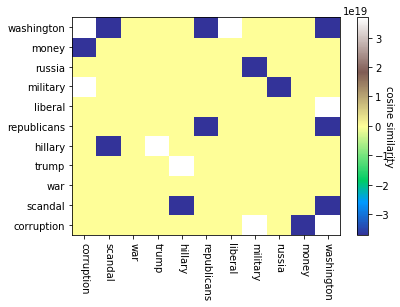

In [153]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [158]:
targetDocs = apsDF['uuid'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

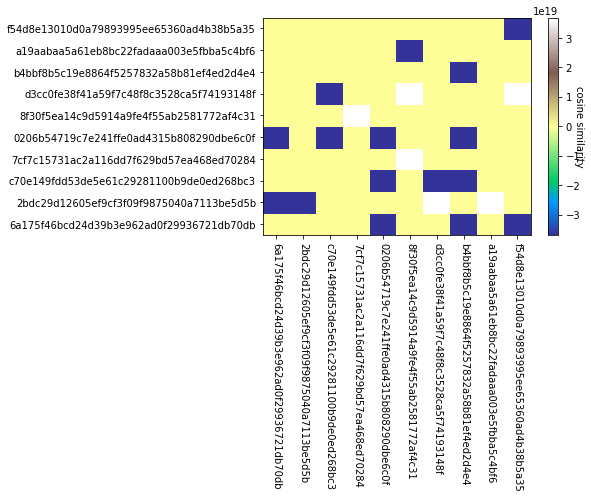

In [159]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [160]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

In [164]:
heatmapMatrixC.shape

(10, 11)

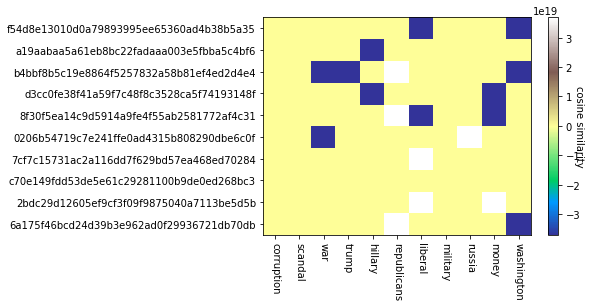

In [161]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We can save the model too...

In [295]:
apsD2V.save('apsW2V_heatmapData')

### Doc-Doc distances

In [ ]:
targetDocs = apsDF['uuid']

heatmapMatrixD_doc_doc = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD_doc_doc.append(column)
heatmapMatrixD_doc_doc = np.array(heatmapMatrixD_doc_doc)
heatmapMatrixD_doc_doc.shape

The heat matrix we obtained above is the required data. Each cell corresponds to the distance between the documents indexed in the corresponding row and column.

### Doc-word distances

In [167]:
heatmapMatrixC_doc_word = []
keywords_new=['war']

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords_new:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC_doc_word.append(column)
heatmapMatrixC_doc_word = np.array(heatmapMatrixC_doc_word)

(12999, 1)

The heat matrix we obtained above is the required data. Each cell corresponds to the distance between the documents and the word `war` indexed in the corresponding row and column.

## Insert analysis here

## Projection

We can also project word vectors to an arbitray semantic dimension. For this purpose, we are going to use our already trained model

In [248]:
final_W2V = gensim.models.word2vec.Word2Vec(all_news['normalized_sents'].sum())  ##creating for req in Q3.

In [296]:
final_W2V.save('projectionData_q3')

First we can visualize with dimension reduction

In [249]:
#words to create dimensions
##tnytTargetWords = ['man','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
#tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

numWords = 200
targetWords = final_W2V.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(final_W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.19747917, -0.45808238,  0.74382532, ...,  1.12340486,
        -2.00511026,  0.32741049],
       [ 0.00381735,  0.06964204, -0.05785301, ...,  1.19125342,
         0.45082492,  0.77319425],
       [ 1.1775521 , -1.32009971,  1.04646337, ...,  2.31835222,
         0.63242376, -0.7112568 ],
       ..., 
       [ 0.33031023,  0.35608962,  0.04387065, ..., -0.35647172,
        -0.8416813 , -0.5071075 ],
       [-0.12341268, -0.93584013,  0.5594396 , ..., -0.05828715,
        -0.89575654,  0.2254519 ],
       [-1.55349922, -1.42011404,  0.08174808, ...,  0.7894761 ,
        -0.22321624,  0.1610751 ]], dtype=float32)

In [250]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

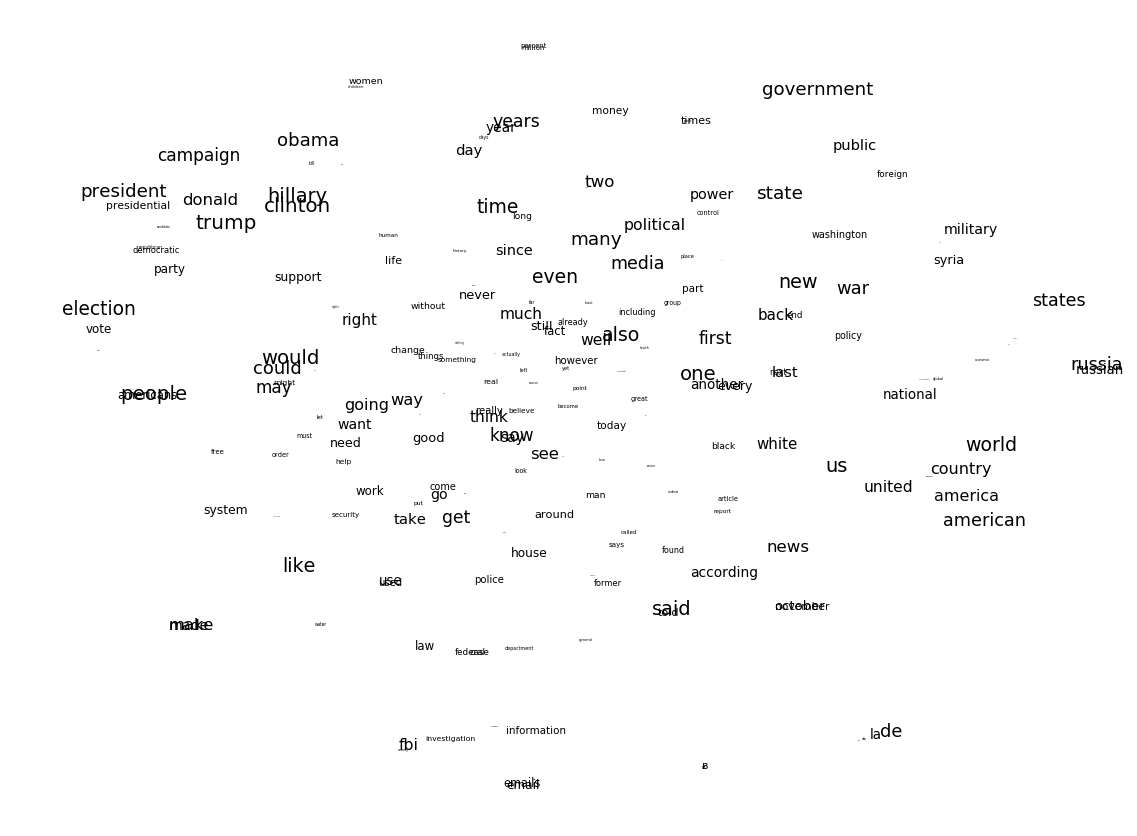

In [251]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(targetWords) - i) / len(targetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [252]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector,np.inf) ## using the 'inf' norm due to bug issues with Frobenius norm
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [278]:
Political_Orientation = dimension(final_W2V, ['republican','republicans','conservative'], ['liberal','progressive','leftist'])
Truthfullness = dimension(final_W2V,['finest','straight','cooperating','heartfelt','plead'],['terrorism','stealing','fraud','scamming','incriminating']) ##somalis, muslim
Race = dimension(final_W2V, ['black','blacks'], ['white', 'whites'])
Institution = dimension(final_W2V, ['federal','government','military'], ['media','paper','judge','fbi'])

Now we define some words to be projected onto the semantic dimensions defined earlier.

In [290]:
plot_words = ['trump','hillary','obama','mueller','lynch','loretta','fbi','military']


In [291]:
def makeDF(model, word_list):
    g = []
    t = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(all_news_W2V[word].reshape(1,-1), Political_Orientation.reshape(1,-1))[0][0])
        t.append(sklearn.metrics.pairwise.cosine_similarity(all_news_W2V[word].reshape(1,-1), Truthfullness.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(all_news_W2V[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(all_news_W2V[word].reshape(1,-1), Institutions.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'politics': g, 'honesty':t,'race': r, 'institution': c}, index = word_list)
    return df

In [292]:
imp_people_df = makeDF(final_W2V, plot_words) 


Define some useful functions for plotting.

In [293]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

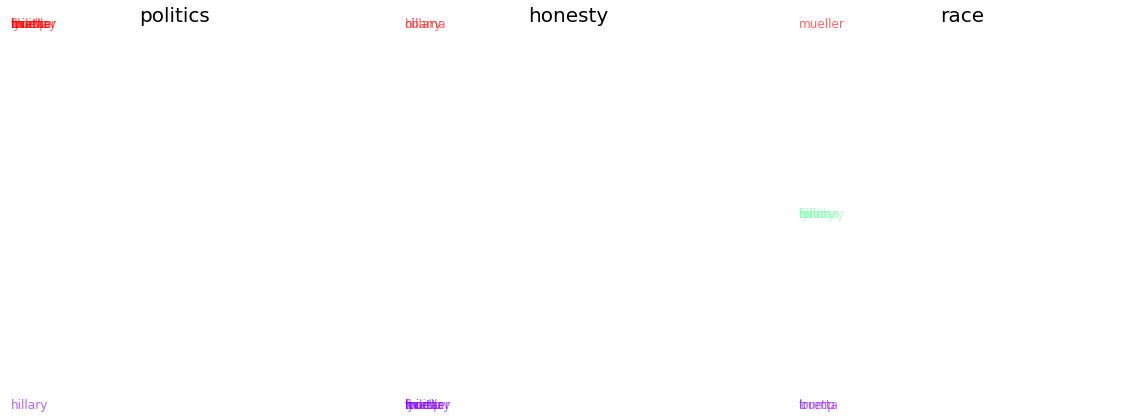

In [294]:
fig = plt.figure(figsize = (20,7))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, imp_people_df, 'politics')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, imp_people_df, 'honesty')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, imp_people_df, 'race')
plt.show()

We see that the words are strongly polarized under the dimension of `politics` and `honesty`. We observe the most variation under `race`. 